In [75]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import os
from io import StringIO

In [ ]:
def WRMSE(predictions, answers):
    
    sum_answer = sum(answers)
    
    if sum_answer.data == 0:
        return torch.sqrt(Variable(torch.tensor(0.001, dtype=torch.float), requires_grad=True))
    
    weight = Variable(torch.tensor([answer/sum_answer for answer in answers], dtype=torch.float))

    loss = (weight * (predictions - answers).pow(2)).sum()
    return torch.sqrt(loss)

In [ ]:
# 데이터 로딩
train_X_data = pd.read_csv('./train_set/train_X_data.csv', index_col='datetime', parse_dates=True)
test_X_data = pd.read_csv('./test_set/test_X_data.csv', index_col='datetime', parse_dates=True)
train_Y_data = pd.read_csv('./train_set/train_Y_data.csv', index_col='datetime', parse_dates=True)
test_Y_data = pd.read_csv('./test_set/test_Y_data.csv', index_col='datetime', parse_dates=True)


# X 데이터의 모든 열을 숫자형으로 변환
# apply(pd.to_numeric, errors='coerce')를 사용하면 변환되지 않는 값이 NaN으로 변환
train_X_data = train_X_data.apply(pd.to_numeric, errors='coerce') 
test_X_data = test_X_data.apply(pd.to_numeric, errors='coerce')

# 타겟 변수의 'Kp' 열을 숫자형으로 변환
train_Y_data['Kp'] = pd.to_numeric(train_Y_data['Kp'], errors='coerce')
test_Y_data['Kp'] = pd.to_numeric(test_Y_data['Kp'], errors='coerce')

# print(train_X_data.head)
# print(train_Y_data.head)

# XGBClassifier

In [101]:
def weighted_root_mean_square_error(y_true, y_pred, weights):
    return np.sqrt(np.mean(weights * (y_true - y_pred) ** 2))

### XGB Model 생성

In [102]:
# XGBoost 모델 정의
# objective : XGBoost가 어떤 문제를 풀어야하는지 ('multi:softmax' : multi-class classification문제)
# num_class : 다중 클래스 분류 문제에서 class 개수
# eval_metric : 모델의 성능을 평가할 때 사용할 지표 (mlogloss : multi-class logarithmic loss 다중클래스 로그 손실)
# merror : multiclass classification error rate (0.75)
# mlogloss : multiclass logloss (0.75)

model = xgb.XGBClassifier(objective='multi:softmax', num_class=10, eval_metric='merror')

# Define XGBRegressor model
#model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')   # RMSE : 0.78

### 하이퍼 파라미터 튜닝, 모델 학습

In [103]:
# 하이퍼파라미터 그리드 정의

param_grid = {
    'n_estimators': [400],   # 트리의 개수 (1000:0.77, 400:0.75)
    'learning_rate': [0.01],   # 학습률
    'subsample': [0.8],  # 각 트리를 학습하는 데 사용되는 데이터 샘플의 비율
}

# TimeSeriesSplit 객체 생성
# 첫 번째 폴드에서는 처음 10%의 데이터를 학습 셋으로 사용하고, 그 다음 10%를 검증 셋으로 사용합니다.
# 두 번째 폴드에서는 처음 20%의 데이터를 학습 셋으로 사용하고, 그 다음 10%를 검증 셋으로 사용합니다.
# 이러한 방식으로 마지막 폴드까지 진행됩니다.
tscv = TimeSeriesSplit(n_splits=10)

# GridSearchCV 정의
# estimator : 튜닝할 모델
# param_grid : 조정한 하이퍼파라미터
# scoring : 모델의 성능을 평가할 때 사용할 지표 : accuracy
# cv : cross validation 할 때 폴드 수 (3개의 폴드로 나누어 3회의 학습과 평가를 반복하여 평균 성능 계산)
# n_jobs : 병렬로 사용할 CPU 코어 수 (-1 : 모든 가용 CPU코어 사용하여 계산 병렬 수행)
# verbose : 출력되는 로그의 상세정도 (숫자 높을 수록 더 자세한 로그 출력)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=tscv, n_jobs=-1, verbose=2)

# GridSearchCV 훈련
grid_search.fit(train_X_data, train_Y_data)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  10.1s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  14.6s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  17.3s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  20.0s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  22.1s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  24.2s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  24.9s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  25.9s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  23.4s
[CV] END learning_rate=0.01, n_estimators=400, subsample=0.8; total time=  22.0s
Best Parameters: {'learning_rate': 0.01, 'n_estimators': 400, 'subsample': 0.8}


### Prediction

In [104]:
# 최적의 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(test_X_data)

### Accuracy

In [ ]:
# 모델 성능 평가
test_rmse = np.sqrt(mean_squared_error(test_Y_data['Kp'], y_pred))

test_weights = pd.Series(np.ones(len(test_Y_data)), index=test_Y_data.index)

print(f'Test RMSE: {test_rmse}')
print("test WRMSE :",WRMSE(torch.tensor(y_pred).float(),torch.tensor(list(test_Y_data['Kp'])).float()))

In [105]:
test_rmse = np.sqrt(mean_squared_error(test_Y_data, y_pred))

test_weights = pd.Series(np.ones(len(test_Y_data)), index=test_Y_data.index)
test_wrmse = weighted_root_mean_square_error(test_Y_data.values.flatten(), y_pred.flatten(), test_weights.values.flatten())

print(f'Test RMSE: {test_rmse}')
print(f'Test WRMSE: {test_wrmse:.2f}')

Test RMSE: 0.7576097958314201
Test WRMSE: 0.76


### 중요 변수 확인

In [106]:
# 중요 변수 확인
feature_importances = best_model.feature_importances_
features = train_X_data.columns

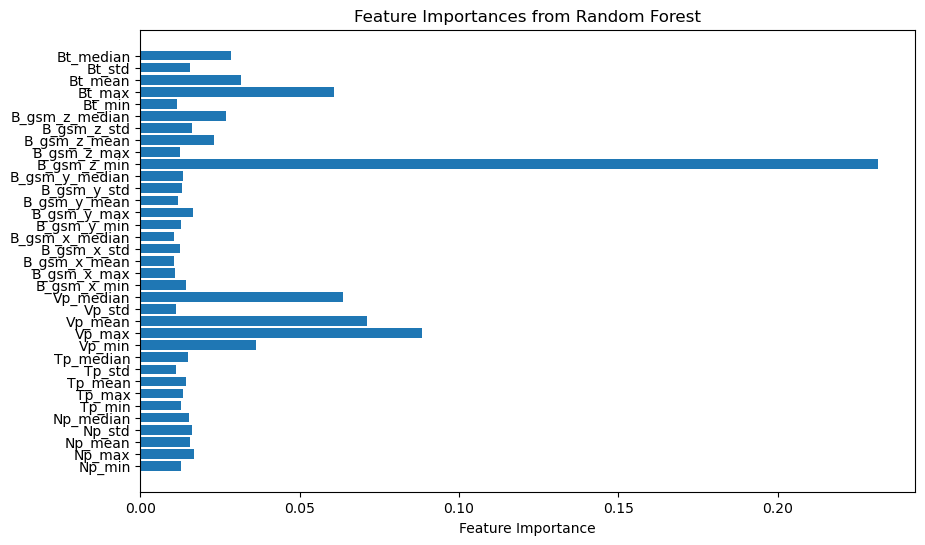

In [107]:
# 중요 변수 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

### 예측 결과 추출

In [108]:
y_pred_df = pd.DataFrame(y_pred, index=test_Y_data.index, columns=['Prediction'])
y_pred_df.to_csv('./Prediction/XGB_Performance.csv')

### 시각화

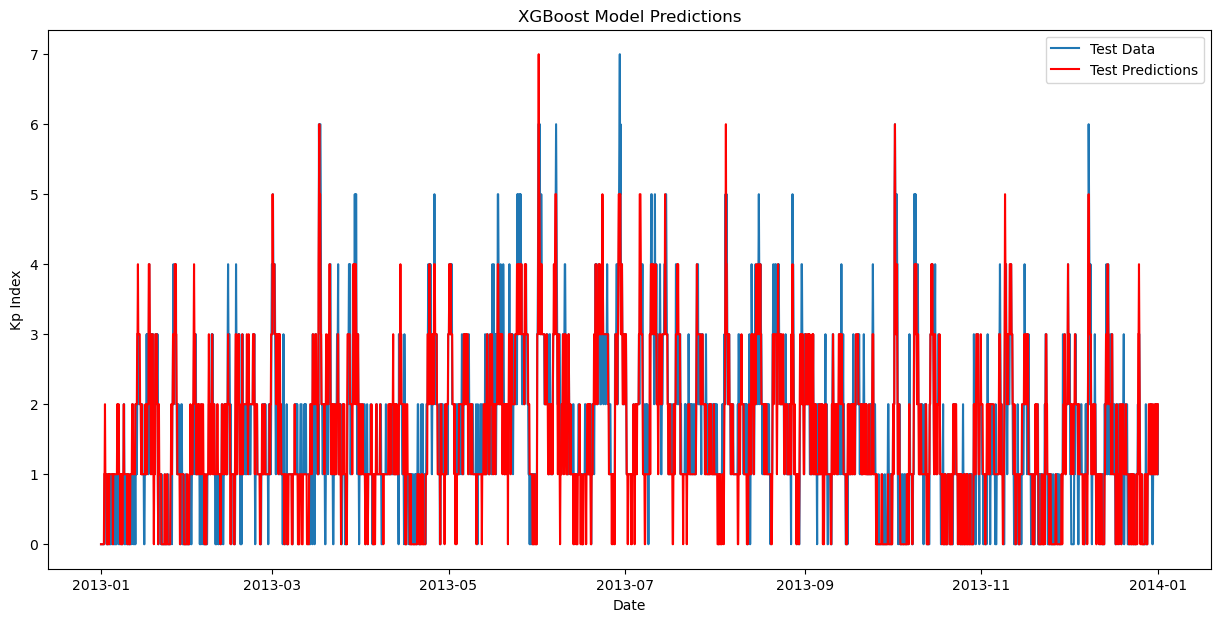

In [109]:
plt.figure(figsize=(15, 7))
plt.plot(test_Y_data, label='Test Data')
plt.plot(y_pred_df, label='Test Predictions', color='red')
plt.title('XGBoost Model Predictions')
plt.xlabel('Date')
plt.ylabel('Kp Index')
plt.legend()
plt.show()